In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

print("Libraries loaded.")

Libraries loaded.


In [14]:
# Load Dataset
print("Loading dataset...")
df = pd.read_csv('../mlpart/anonymized_full_release_competition_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

Loading dataset...


/var/folders/vj/q_y98g4s46vdtkgrt0n9q4c00000gn/T/ipykernel_37935/1542040467.py:3: DtypeWarning: Columns (76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../mlpart/anonymized_full_release_competition_dataset.csv')


Dataset shape: (942816, 82)
Columns: 82


In [15]:
# Enhanced Feature Selection
# Use more contextual features from the dataset
base_features = ['timeTaken', 'correct', 'attemptCount', 'hintCount']

# Add historical/contextual features that capture learning trajectory
contextual_features = [
    'frPast5HelpRequest',      # Help requests in past 5 problems
    'frPast8WrongCount',       # Wrong answers in past 8 problems
    'totalFrPercentPastWrong', # Overall error rate
    'frTimeTakenOnScaffolding',# Time on scaffolding (struggle indicator)
    'AveCorrect',              # Student's average correctness
    'AveKnow',                 # Student's average knowledge (if available)
    'bottomHint',              # Used bottom-out hint (gave up)
    'scaffold'                 # Needed scaffolding
]

features = base_features + contextual_features
target = 'Ln'

# Convert all to numeric
print("Converting columns to numeric...")
for col in features + [target]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in dataset")
        features.remove(col)

# Drop rows with NaN
df_clean = df.dropna(subset=features + [target]).copy()
print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"Using {len(features)} features")

# Check target distribution
print(f"\nTarget (Ln) statistics:")
print(df_clean[target].describe())

Converting columns to numeric...

Cleaned dataset shape: (942807, 82)
Using 12 features

Target (Ln) statistics:
count    942807.000000
mean          0.195156
std           0.273796
min           0.001100
25%           0.036066
50%           0.067878
75%           0.197923
max           1.000000
Name: Ln, dtype: float64


In [16]:
# Feature Engineering - Create interaction features
print("Engineering features...")

# Efficiency: correct answer with low time/attempts
df_clean['efficiency'] = df_clean['correct'] / (df_clean['attemptCount'] + 1)

# Struggle indicator: high attempts + hints
df_clean['struggle_score'] = df_clean['attemptCount'] * 0.5 + df_clean['hintCount'] * 0.5

# Time per attempt (normalized)
df_clean['time_per_attempt'] = df_clean['timeTaken'] / (df_clean['attemptCount'] + 1)

# Add engineered features to feature list
engineered_features = ['efficiency', 'struggle_score', 'time_per_attempt']
features_enhanced = features + engineered_features

print(f"Total features after engineering: {len(features_enhanced)}")

Engineering features...
Total features after engineering: 15


In [17]:
# Train-Test Split
X = df_clean[features_enhanced]
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Testing samples: {X_test.shape[0]:,}")

Training samples: 754,245
Testing samples: 188,562


In [18]:
# Train Multiple Models and Compare
print("\n=== Training Random Forest ===")
rf_model = RandomForestRegressor(
    n_estimators=200,      # More trees
    max_depth=15,          # Deeper trees
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
print(f"Random Forest - R2: {rf_r2:.4f}, MSE: {rf_mse:.4f}")

print("\n=== Training Gradient Boosting ===")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)
gb_mse = mean_squared_error(y_test, gb_pred)
print(f"Gradient Boosting - R2: {gb_r2:.4f}, MSE: {gb_mse:.4f}")

# Select best model
if gb_r2 > rf_r2:
    best_model = gb_model
    best_name = "Gradient Boosting"
    best_r2 = gb_r2
else:
    best_model = rf_model
    best_name = "Random Forest"
    best_r2 = rf_r2

print(f"\n✓ Best Model: {best_name} (R2: {best_r2:.4f})")


=== Training Random Forest ===
Random Forest - R2: 0.6383, MSE: 0.0271

=== Training Gradient Boosting ===
Gradient Boosting - R2: 0.6010, MSE: 0.0299

✓ Best Model: Random Forest (R2: 0.6383)



Top 10 Most Important Features:
                 feature  importance
              efficiency    0.583032
 totalFrPercentPastWrong    0.131194
                 AveKnow    0.122614
      frPast5HelpRequest    0.050166
              AveCorrect    0.037150
frTimeTakenOnScaffolding    0.024188
       frPast8WrongCount    0.017767
        time_per_attempt    0.011050
               timeTaken    0.010615
               hintCount    0.006168


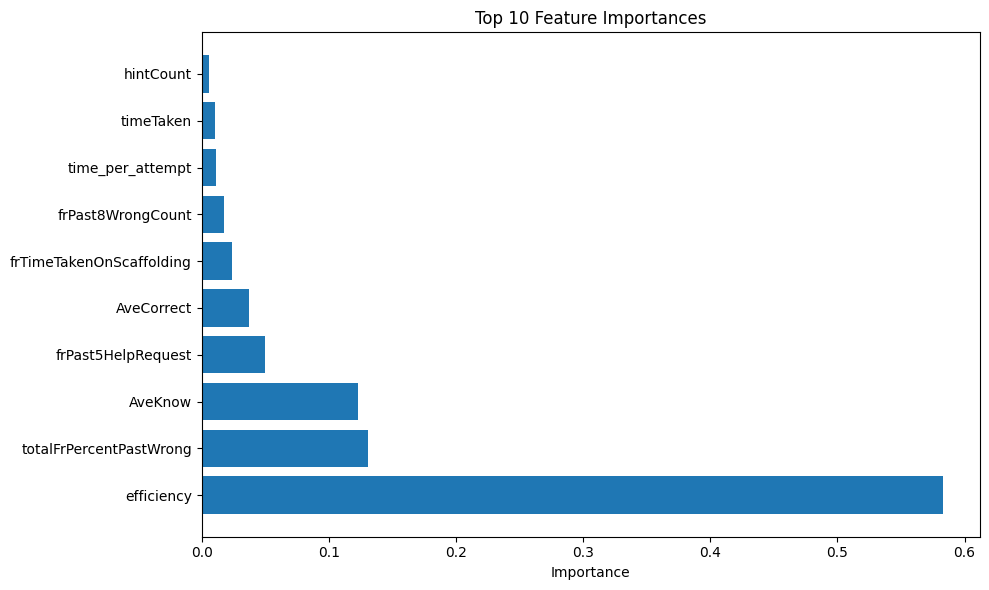

In [19]:
# Feature Importance Analysis
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features_enhanced,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df.head(10)['feature'], feature_importance_df.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [20]:
# Save Best Model and Feature List
print("\nSaving model...")
joblib.dump(best_model, '../backend/mastery_model.pkl')
joblib.dump(features_enhanced, '../backend/model_features.pkl')
print(f"✓ Model saved to ../backend/mastery_model.pkl")
print(f"✓ Features saved to ../backend/model_features.pkl")
print(f"\nFinal R² Score: {best_r2:.4f}")


Saving model...
✓ Model saved to ../backend/mastery_model.pkl
✓ Features saved to ../backend/model_features.pkl

Final R² Score: 0.6383
